In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
### Classes: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [51]:
## Data Loading and Splitting
data=pd.read_csv("../FaceRecognition.csv")
data=data.drop(columns='Unnamed: 0')
Train_data=data[data['X2306']=='Training'].drop(columns='X2306')
Test_data=data[data['X2306']=='PrivateTest'].drop(columns='X2306')
Train_labels=Train_data.iloc[:,0].values
Test_labels=Test_data.iloc[:,0].values
Train_data=Train_data.drop(columns='X1').values
Test_data=Test_data.drop(columns='X1').values


In [52]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(48, 48),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

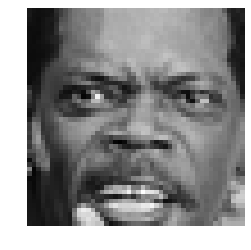

In [53]:
vectortoimg(Train_data[10])

In [54]:
### Applying PCA for Dimension Reduction
meanvector=np.mean(Train_data,axis=0)


In [55]:
Z_Train=Train_data-meanvector

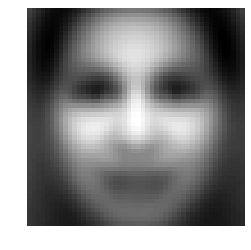

In [61]:
vectortoimg(meanvector)

In [63]:
C_Train=np.cov(Z_Train.T)  ## Check the shape, should be square matrix with dimensions as number of features : here 2304

In [65]:
Eigenvalues,Eigenvectors=np.linalg.eigh(C_Train)

In [66]:
np.argmax(Eigenvalues)  ## Largest Eigen Value is at the last index. So, Flipping is required   

2303

In [71]:
row=Eigenvectors[-1,:];col=Eigenvectors[:,-1];
print("Row dot product value: Max/Min " + str(max(np.dot(C_Train,row)-(Eigenvalues[-1]*row)))) ## Rows are not eigen vectors
print ("Column dot product value: Max/Min"+str(max(np.dot(C_Train,col)-(Eigenvalues[-1]*col))))  #### matrix* EigenVector==EigenValue* EigenVector ,Therefore, Columns are EigenVectors

Row dot product value: Max/Min 225060.78302759485
Column dot product value: Max/Min1.7462298274040222e-10


In [72]:
## Columns are Eigen Vectors. Taking Transpose and Inverse
Eigenvalues=np.flipud(Eigenvalues)
Eigenvectors=np.flipud(Eigenvectors.T)


In [74]:
row=Eigenvectors[0,:]
## Checking Again:
min(np.dot(C_Train,row)-(Eigenvalues[0]*row))  ## Rows are eigen vectors here 



-7.057678885757923e-10

In [76]:
np.allclose(np.dot(C_Train,row),Eigenvalues[0]*row)  ## Check 2  ## We finally got ordered Eigen Vectors and Eigen Values

True

In [78]:
prin_comp=np.dot(Z_Train,Eigenvectors.T)   ### We always have to find principle components this way for Training Data Set

In [80]:
prin_comp.shape

(28709, 2304)

In [169]:
### How many Principle Components to use:

Eigenvalues

array([2.66218450e+06, 9.02562303e+05, 8.70360713e+05, ...,
       4.05537675e+00, 4.01708190e+00, 3.67712297e+00])

In [184]:
cumulative_variance=[]
net_variance=[]
temp=0.0
E_sum=np.sum(Eigenvalues)
for i in Eigenvalues:
    temp=temp+i
    cumulative_variance.append(temp*100/E_sum)
    net_variance.append(i*100/E_sum)
    

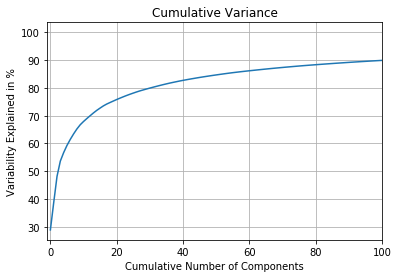

In [211]:
plt.plot(range(len(cumulative_variance)),cumulative_variance)
plt.title("Cumulative Variance")
plt.xlim(right=100,left=-1)
plt.xlabel("Cumulative Number of Components")
plt.ylabel("Variability Explained in %")
plt.grid()


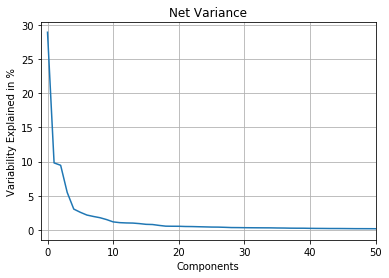

In [212]:
plt.plot(range(len(net_variance)),net_variance)
plt.xlim(right=50,left=-1)
plt.title("Net Variance")
plt.xlabel("Components")
plt.ylabel("Variability Explained in %")
plt.grid()


In [225]:
pca_num_components=len(list(filter(lambda x: x <= 75, cumulative_variance)))  ### 75% Variability Explained with 19 components

In [231]:
Train_pca=pd.DataFrame(prin_comp[:,:pca_num_components])

(28709, 19)

In [247]:
np.max(pd.DataFrame.max(Train_pca).values)

5729.926150567473

In [248]:
np.min(pd.DataFrame.min(Train_pca).values)

-5996.369551655992

In [259]:
mins=pd.DataFrame.min(Train_pca).values
maxs=pd.DataFrame.max(Train_pca).values

-5996.369551655992

In [257]:
np.ceil(np.log2(28709/7))+1  ### Number of bins

14.0

In [217]:
#x=np.dot(prin_comp[:,:pca_num_components],Eigenvectors[:pca_num_components,:])+ meanvector

In [ ]:
def Hist2D(mydata,mybins): ## Insert a dataframe
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    mins
    maxs
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    return HN,HP
        